In [40]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

In [2]:
def data_loading(data_dir):
  
  images=[]
  labels=[]

  for subfolder in os.listdir(data_dir):
    subfolder_path=os.path.join(data_dir,subfolder)
    if not os.path.isdir(subfolder_path):
      continue
    for image_filename in os.listdir(subfolder_path):
      image_path=os.path.join(subfolder_path,image_filename)

      images.append(image_path)
      labels.append(subfolder)

  df=pd.DataFrame({'images':images,'labels':labels})
  return df

In [3]:
data_dir = r"C:\Users\tugca\Desktop\Python\project_datasets\tomato\train"
df = data_loading(data_dir)


In [4]:
data_balance = df.labels.value_counts()
data_balance

labels
Tomato___Bacterial_spot                          1000
Tomato___Early_blight                            1000
Tomato___healthy                                 1000
Tomato___Late_blight                             1000
Tomato___Leaf_Mold                               1000
Tomato___Septoria_leaf_spot                      1000
Tomato___Spider_mites_Two-spotted_spider_mite    1000
Tomato___Target_Spot                             1000
Tomato___Tomato_mosaic_virus                     1000
Tomato___Tomato_Yellow_Leaf_Curl_Virus           1000
Name: count, dtype: int64

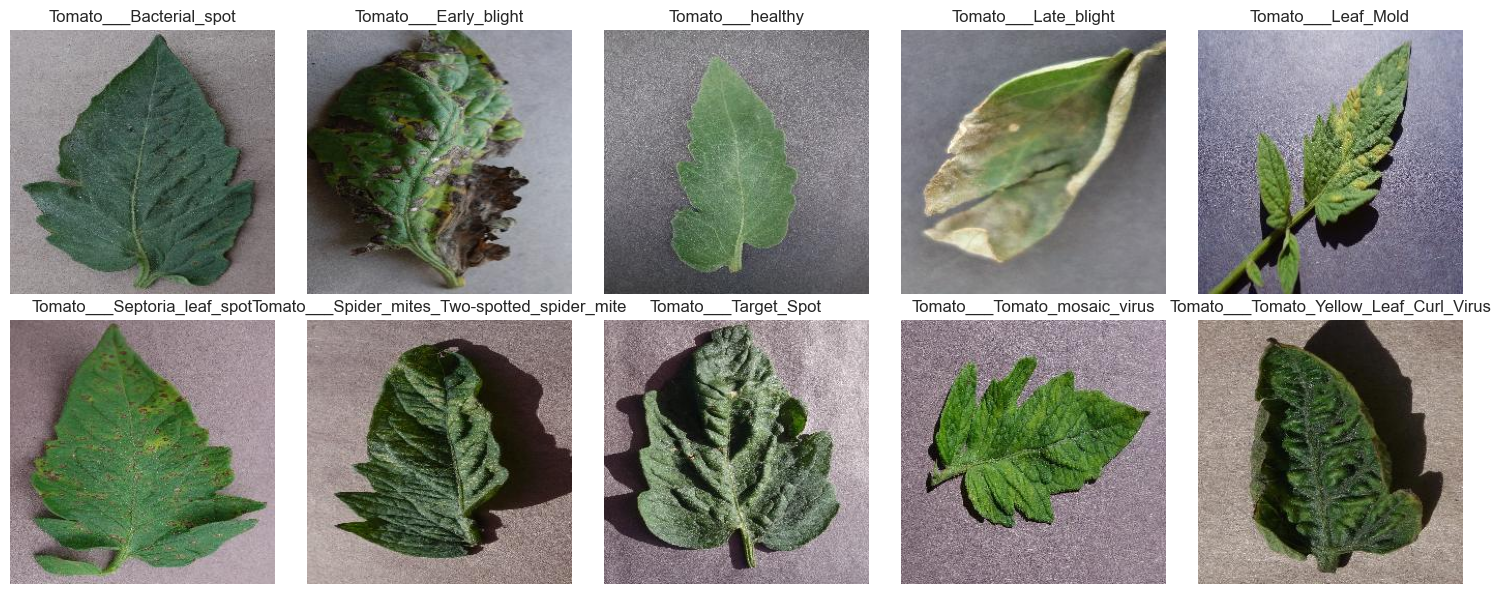

In [41]:
classes = df['labels'].unique()
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, cls in enumerate(classes):
    cls_images = df[df['labels'] == cls]['images'].tolist()
    random_image = random.choice(cls_images)
    img = plt.imread(random_image)
    
    row = i // 5
    col = i % 5
    axs[row, col].imshow(img)
    axs[row, col].set_title(cls)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [5]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [44]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)


train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col='images',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb', 
                                       shuffle= True,
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col='images',
                                       y_col='labels',
                                       target_size= img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col='images',
                                      y_col='labels',
                                      target_size= img_size,
                                      class_mode='categorical',
                                      color_mode='rgb',
                                      shuffle= False,
                                      batch_size= batch_size)

Found 8000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.


In [7]:
input_shape=(224, 224, 3)
class_counts = 10

base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape =input_shape,
                   pooling= 'max')

for layer in base_model.layers[:15]:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)   
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "softmax")(x)

VGG16_model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
for layer in VGG16_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_max_pooling2d True
flatten True
dense True
dropout True
dense_1 True
dense_2 True
dense_3 True
dense_4 True


In [9]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

In [10]:
VGG16_model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [11]:
#learning_rate_reduction = ReduceLROnPlateau(
    #monitor='val_accuracy',
    #patience=5,
    #verbose=1,
    #factor=0.5,
    #min_lr=1e-7)

In [12]:
VGG16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
epochs = 8   
VGG16_history = VGG16_model.fit(train_gen,
                                epochs= epochs,
                                verbose= 1,
                                validation_data=valid_gen,
                                shuffle= False)

Epoch 1/8
500/500 [==============================] - 764s 2s/step - loss: 1.0679 - accuracy: 0.6321 - val_loss: 0.4393 - val_accuracy: 0.8300
Epoch 2/8
500/500 [==============================] - 752s 2s/step - loss: 0.3560 - accuracy: 0.8821 - val_loss: 0.2449 - val_accuracy: 0.9160
Epoch 3/8
500/500 [==============================] - 769s 2s/step - loss: 0.2077 - accuracy: 0.9305 - val_loss: 0.3263 - val_accuracy: 0.8930
Epoch 4/8
500/500 [==============================] - 768s 2s/step - loss: 0.1261 - accuracy: 0.9586 - val_loss: 0.2613 - val_accuracy: 0.9020
Epoch 5/8
500/500 [==============================] - 772s 2s/step - loss: 0.0910 - accuracy: 0.9703 - val_loss: 0.2535 - val_accuracy: 0.9220
Epoch 6/8
500/500 [==============================] - 772s 2s/step - loss: 0.0799 - accuracy: 0.9715 - val_loss: 0.2011 - val_accuracy: 0.9400
Epoch 7/8
500/500 [==============================] - 774s 2s/step - loss: 0.0715 - accuracy: 0.9790 - val_loss: 0.1974 - val_accuracy: 0.9400
Epoch 

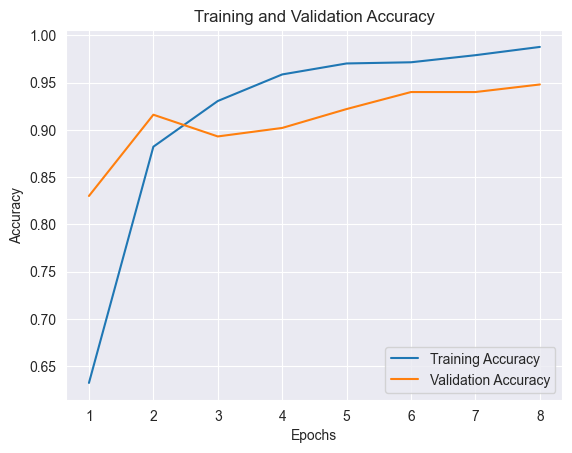

Text(0.5, 1.0, 'Training and Validation Loss')

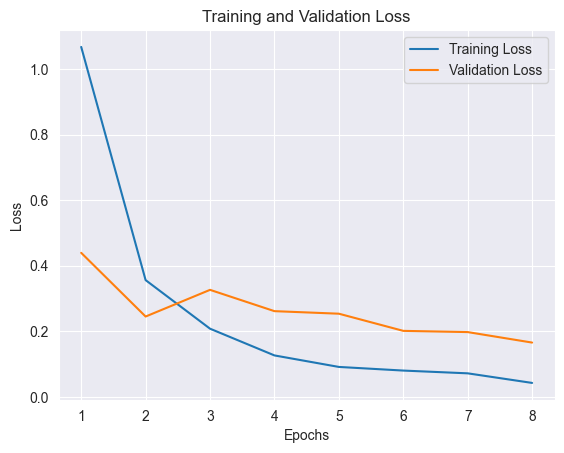

In [25]:
train_acc = VGG16_history.history['accuracy']
val_acc = VGG16_history.history['val_accuracy']
epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

train_loss = VGG16_history.history['loss']
val_loss = VGG16_history.history['val_loss']

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [26]:
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

model_evaluation(VGG16_model)


63/63 [==============================] - 69s 1s/step - loss: 0.1658 - accuracy: 0.9530


63/63 [==============================] - 64s 1s/step


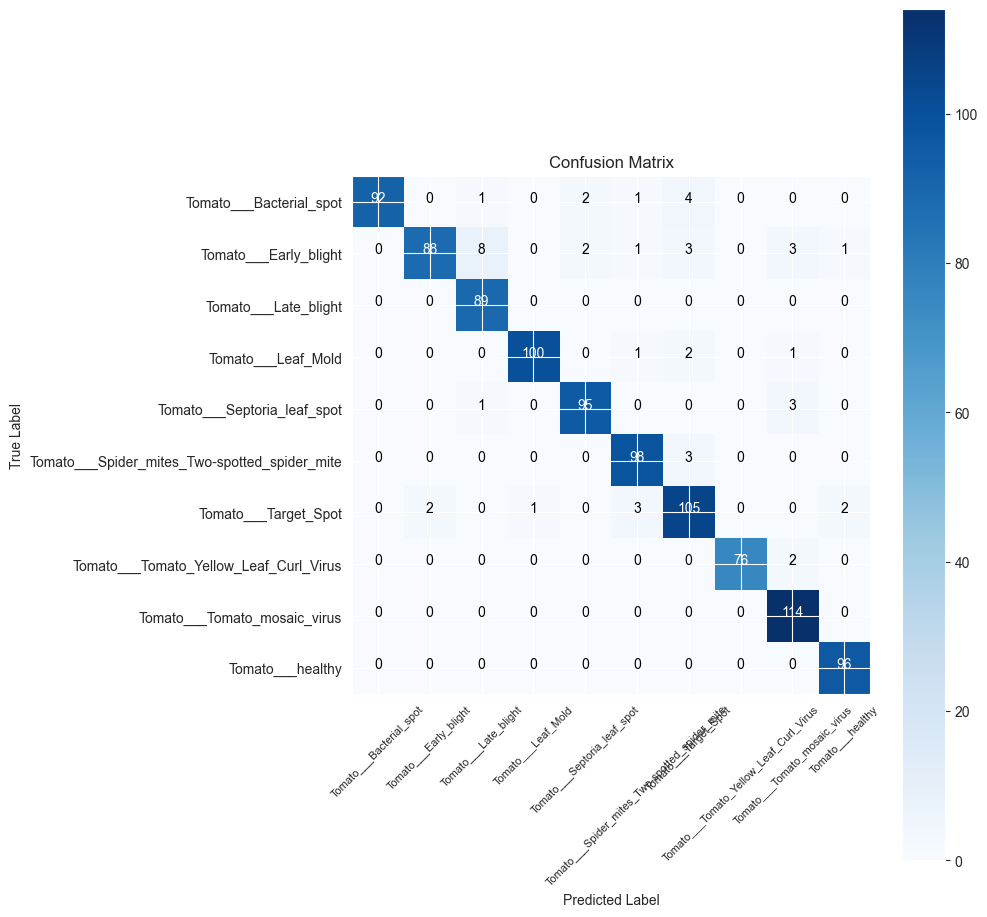

In [29]:
preds = VGG16_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

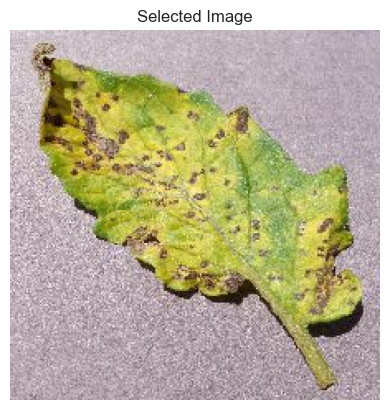

1/1 [==============================] - 0s 90ms/step
Model Prediction: Tomato___Septoria_leaf_spot
True Label: Tomato___Septoria_leaf_spot


In [35]:
random_idx = random.randint(0, len(test_gen.filenames) - 1)
img_path = test_gen.filepaths[random_idx]

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0 

plt.imshow(img)
plt.axis('off')
plt.title('Selected Image')
plt.show()

prediction = VGG16_model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]
class_labels = list(test_gen.class_indices.keys())

true_class_idx = test_gen.classes[random_idx]
true_class_label = class_labels[true_class_idx]

print(f"Model Prediction: {class_labels[predicted_class]}")
print(f"True Label: {true_class_label}")